# Prep data

In [2]:
import ast
import re
import pandas as pd

df = pd.read_csv("data.csv")
print(f"original dataframe shape: {df.shape}")

df = df[
    (df["annot_type"] == "Main Description") & (df["annot_source"] == "Ingram")
].copy()
df["BISAC"] = df["BISAC"].apply(ast.literal_eval)
print(f'"Main Description", "Ingram" dataframe shape: {df.shape}')

# convert BISAC to only alpha characters
df["BISAC"] = df["BISAC"].apply(
    lambda x: [re.sub(r"[^a-zA-Z]", "", bisac) for bisac in x]
)

# remove duplicate BISACs
df["BISAC"] = df["BISAC"].apply(lambda x: list(set(x)))

# get set of bisacs that have at least 500 books
bisac_counts = df["BISAC"].explode().value_counts()
bisac_counts = bisac_counts[bisac_counts >= 500]
bisac_counts = bisac_counts.index
bisacs_500 = set(bisac_counts)
print("bisacs with at least 500 books:")
print(bisacs_500)

# create a new dataframe with only books that have all of their bisacs in bisacs_500
df = df[df["BISAC"].apply(lambda x: all(bisac in bisacs_500 for bisac in x))]
print(
    f"dataframe with only books that have all of their bisacs in bisacs_500 shape: {df.shape}"
)

df

/tmp/ipykernel_1288431/2095119486.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


original dataframe shape: (148409, 5)
"Main Description", "Ingram" dataframe shape: (59633, 5)
bisacs with at least 500 books:
{'OCC', 'SOC', 'POE', 'MUS', 'COM', 'LCO', 'REF', 'JUV', 'CKB', 'ART', 'PHI', 'FIC', 'CRA', 'TRU', 'DRA', 'FAM', 'HUM', 'REL', 'BIO', 'SEL', 'SPO', 'BUS', 'LIT', 'HIS', 'NAT', 'LAN', 'PSY', 'MED', 'TEC', 'POL', 'SCI', 'YAF', 'TRV', 'PHO', 'PER', 'HEA'}
dataframe with only books that have all of their bisacs in bisacs_500 shape: (55280, 5)


,isbn13,BISAC,annot_type,annot_source,annot
0,9780001847118,"[JUV, YAF]",Main Description,Ingram,This is a fantasy adventure by Alan Garner.
1,9780002006781,[HEA],Main Description,Ingram,"In those first heady days of a relationship, c..."
2,9780002007580,"[TRU, HIS]",Main Description,Ingram,"In 1972, 11 Israeli athletes were murdered at ..."
4,9780002189613,[SPO],Main Description,Ingram,In a world where it is becoming increasingly d...
14,9780006391357,[FIC],Main Description,Ingram,"A born skeptic, journalist Joe Oakes believes ..."
...,...,...,...,...,...
148400,9789881998286,"[HIS, BIO]",Main Description,Ingram,In 1898 a young Englishman walked into a homos...
148401,9789881998460,[CKB],Main Description,Ingram,"In 1969, millions of Chinese teenagers were fo..."
148402,9789888273454,"[TRV, HIS]",Main Description,Ingram,A breathtaking romp through the city's Tokyo's...
148403,9789888422609,[HIS],Main Description,Ingram,Somebody knew. Who knew? Did Winston Churchill...


# Classification

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
import numpy as np

""" still including rows with 0 books?"""
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df["annot"], df["BISAC"], test_size=0.2, random_state=42
)
from sklearn.preprocessing import MultiLabelBinarizer

X_train = X_train.fillna("")
X_test = X_test.fillna("")

# Convert labels to binary array format
mlb = MultiLabelBinarizer()
y_train_binary = mlb.fit_transform(y_train)
y_test_binary = mlb.transform(y_test)

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=10000)

classifier = LogisticRegression(random_state=42)

# Create a pipeline
pipeline = Pipeline([("tfidf", vectorizer), ("clf", MultiOutputClassifier(classifier))])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train_binary)

# Predict on the test data
predictions = pipeline.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test_binary, predictions, target_names=mlb.classes_, zero_division=0
    )
)

              precision    recall  f1-score   support

         ART       0.86      0.30      0.44       165
         BIO       0.79      0.45      0.58      1075
         BUS       0.91      0.56      0.69       590
         CKB       0.97      0.82      0.89       706
         COM       0.97      0.61      0.75       220
         CRA       0.94      0.41      0.57       107
         DRA       0.89      0.28      0.42       144
         FAM       0.90      0.13      0.23       205
         FIC       0.89      0.88      0.89      3816
         HEA       0.85      0.48      0.61       378
         HIS       0.83      0.56      0.67      1292
         HUM       0.50      0.02      0.03       132
         JUV       0.90      0.36      0.52       449
         LAN       0.86      0.07      0.14        81
         LCO       0.75      0.03      0.06       193
         LIT       0.77      0.15      0.25       245
         MED       0.53      0.13      0.21       129
         MUS       0.87    

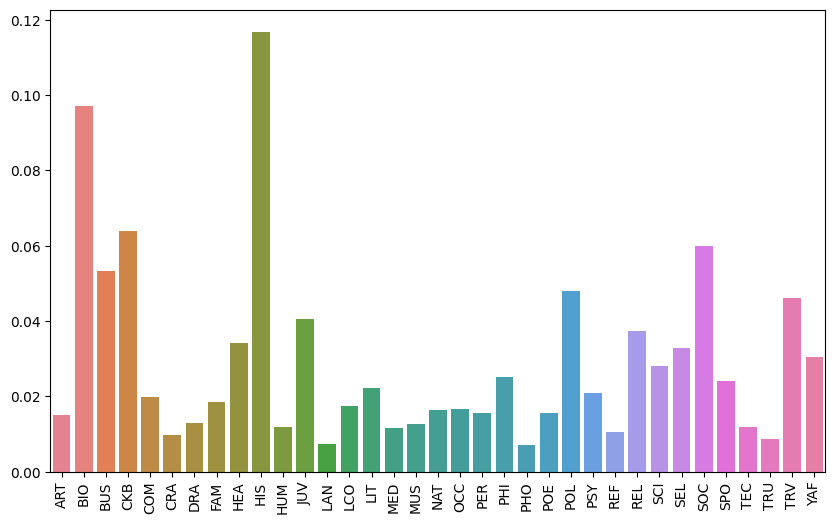

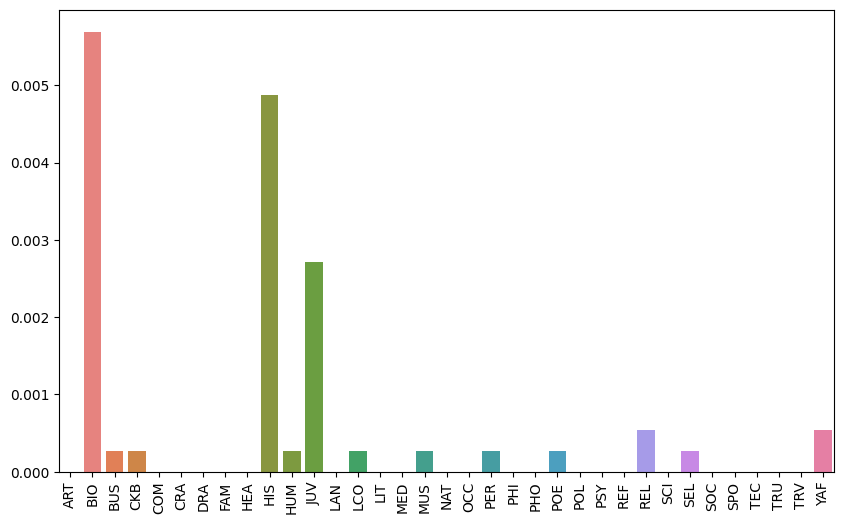

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

fic_mlb_index = mlb.classes_.tolist().index("FIC")
fic_test_indices = np.where(y_test_binary[:, fic_mlb_index] == 1)[0]
fic_only_test_indices = np.array(
    [index for index in fic_test_indices if np.sum(y_test_binary[index]) == 1]
)

fic_only_test_predictions = predictions[fic_only_test_indices]
fic_only_test_predictions_df = pd.DataFrame(
    fic_only_test_predictions, columns=mlb.classes_
)
fic_only_test_predictions_df.drop(columns="FIC", inplace=True)


# Increase figure size
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)

# Plot the distribution of y_test_binary
y_test_binary_labeled = pd.DataFrame(y_test_binary, columns=mlb.classes_)
y_test_binary_labeled.drop(columns="FIC", inplace=True)
sns.barplot(data=y_test_binary_labeled, errorbar=None)
plt.show()
plt.figure(figsize=(10, 6))
plt.xticks(rotation=90)

# Plot the predictions
sns.barplot(data=fic_only_test_predictions_df, errorbar=None)

plt.show()

# Balanced Classification

In [49]:
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Assuming df is your original DataFrame with columns "annot" and "BISAC"
# Create a new DataFrame with works having a single BISAC code
single_bisac_df = df[df["BISAC"].apply(lambda x: len(x) == 1)]
single_bisac_df["BISAC"] = single_bisac_df["BISAC"].apply(lambda x: x[0])

# Filter BISAC codes with counts greater than 20
bisac_counts = single_bisac_df["BISAC"].value_counts()
selected_bisac_codes = bisac_counts[bisac_counts > 20].index
single_bisac_df_filtered = single_bisac_df[
    single_bisac_df["BISAC"].isin(selected_bisac_codes)
]

# Use the maximum count among selected BISAC codes
max_class_count = single_bisac_df_filtered["BISAC"].value_counts().max()

# Balance the dataset by resampling each class
balanced_df = pd.DataFrame()
for label in single_bisac_df_filtered["BISAC"].unique():
    class_samples = resample(
        single_bisac_df_filtered[single_bisac_df_filtered["BISAC"] == label],
        replace=True,
        n_samples=max_class_count,
        random_state=42,
    )
    balanced_df = pd.concat([balanced_df, class_samples])

# Split the balanced data into train and test sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    balanced_df["annot"], balanced_df["BISAC"], test_size=0.2, random_state=42
)

X_train_balanced = X_train_balanced.fillna("")
X_test_balanced = X_test_balanced.fillna("")

# Convert labels to binary array format
mlb = MultiLabelBinarizer()
y_train_binary_balanced = mlb.fit_transform(y_train_balanced)
y_test_binary_balanced = mlb.transform(y_test_balanced)

# Initialize TF-IDF Vectorizer
vectorizer_balanced = TfidfVectorizer(max_features=10000)

classifier_balanced = LogisticRegression(random_state=42)

# Create a pipeline for balanced data
pipeline_balanced = Pipeline(
    [
        ("tfidf", vectorizer_balanced),
        ("clf", MultiOutputClassifier(classifier_balanced)),
    ]
)

# Fit the pipeline on the balanced training data
pipeline_balanced.fit(X_train_balanced, y_train_binary_balanced)

# Predict on the balanced test data
predictions_balanced = pipeline_balanced.predict(X_test_balanced)

# Evaluate the model on balanced data
print(
    classification_report(
        y_test_binary_balanced,
        predictions_balanced,
        target_names=mlb.classes_,
        zero_division=0,
    )
)

/tmp/ipykernel_1288431/1878746121.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_bisac_df["BISAC"] = single_bisac_df["BISAC"].apply(lambda x: x[0])
/home2/hstropkay/76-final-project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           A       0.96      0.97      0.96     29031
           B       0.98      0.87      0.92     10976
           C       0.98      0.93      0.96     32937
           D       1.00      1.00      1.00      7386
           E       0.99      0.99      0.99     29519
           F       0.95      0.90      0.93     14816
           H       0.98      0.93      0.96     18288
           I       0.97      0.87      0.92     22037
           J       0.94      0.78      0.85      3600
           K       1.00      0.94      0.97      3712
           L       0.98      0.98      0.98     22008
           M       0.99      0.99      0.99     18464
           N       1.00      1.00      1.00      7183
           O       0.97      0.96      0.97     33043
           P       0.98      0.98      0.98     25744
           R       0.99      0.98      0.98     29304
           S       0.98      0.95      0.97     29171
           T       0.99    